# Exploratory Data Analysis with R and BigQuery
## Overview

This notebook illustrates how to perform Exploratory Data Analysis (EDA) using R, on data extracted from BigQuery. After analysing and processing the data, the transformed data is stored in Cloud Storage (GCS) for further Machine Learning (MLL) tasks.

R is one of the most widely used programming languages for statistical modeling, which has a large and active community of data scientists and ML professional. 
With over 10,000 packages in the open-source repository of CRAN, R caters to all statistical data analysis applications, ML, and visualisation.


## Dataset
The dataset used in this tutorial is natality data, which describes all United States births registered in the 50 States, the District of Columbia, and New York City from 1969 to 2008, with more than 137 million records.
The dataset is available in [BigQuery public dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality&page=table&_ga=2.99329886.-1705629017.1551465326&_gac=1.109796023.1561476396.CI2rz-z4hOMCFc6RhQods4oEXA).

In this notebook, we focus on Exploratory Data Analysis, while the goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.

## Objective
The goal of this tutorial is to:
1. Query and analyse data from BigQuery using bigrquery R library
2. Prepare and store data in Cloud Storage for ML 


## Costs
This tutorial uses billable components of Google Cloud Platform (GCP):
1. AI Platform Notebooks
2. BigQuery
3. Cloud Storage

Learn about GCP pricing, use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


In [1]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          5.1                         
year           2018                        
month          07                          
day            02                          
svn rev        74947                       
language       R                           
version.string R version 3.5.1 (2018-07-02)
nickname       Feather Spray               

## 0. Setup 

Install and import the required libraries.

This may take several minutes if not installed already...

In [2]:
# install the required R libraries
install.packages(c("bigrquery", "ggplot2", "readr"))

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
# import R libraries
library(bigrquery) # used for querying BigQuery
library(ggplot2) # used for visualisation
library(dplyr) # used for data wrangling
library(readr) # required by bigrquery


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Set your `PROJECT_ID` and `BUCKET_NAME`

In [4]:
# Provide authentication through the JSON service account key
set_service_token("service-account-key.json")

# Set the project id
PROJECT_ID <- "r-on-gcp"

# Set yout GCS bucket
BUCKET_NAME <- "r-on-gcp"

## 1. Querying Data from BigQuery 

### 1.1. Prepare the BigQuery query

In [5]:
sql_query <- "
    SELECT
      ROUND(weight_pounds, 2) AS weight_pounds ,
      is_male,
      mother_age,
      mother_race,
      plurality,
      gestation_weeks,
      mother_married,
      cigarette_use,
      alcohol_use,
      CAST(ABS(FARM_FINGERPRINT(
        CONCAT(
        CAST(YEAR AS STRING), CAST(month AS STRING), CAST(weight_pounds AS STRING)))) AS STRING) AS key
    FROM
        publicdata.samples.natality
    WHERE 
      year > 2000
      AND weight_pounds > 0
      AND mother_age > 0
      AND plurality > 0
      AND gestation_weeks > 0
      AND month > 0
    LIMIT %s
"

### 1.2. Execute the query 
The data will be retreived from BigQuery, and the results will be stored in an in-memory dataframe.

In [6]:
sample_size <- 10000
sql_query <- sprintf(sql_query, sample_size)

natality_data <- bq_table_download(
    bq_project_query(
        PROJECT_ID, 
        query=sql_query
    )
)

### 1.3. View the query results

In [7]:
# View the query result
head(natality_data)

weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use,key
6.19,TRUE,42,1,1,37,TRUE,NA,FALSE,3501749140345931900
6.53,TRUE,42,1,2,38,TRUE,NA,NA,5679154363719514271
7.86,TRUE,43,1,1,38,TRUE,NA,FALSE,4817915535495958568
5.37,FALSE,42,1,1,37,TRUE,NA,FALSE,2386951256774305990
5.10,TRUE,43,1,3,35,TRUE,NA,FALSE,6466467252028013362
5.94,TRUE,42,2,1,33,FALSE,NA,FALSE,817002219589810482


In [8]:
# View the results summary
summary(natality_data)

 weight_pounds     is_male          mother_age     mother_race    
 Min.   : 0.500   Mode :logical   Min.   :13.00   Min.   : 1.000  
 1st Qu.: 6.620   FALSE:4892      1st Qu.:22.00   1st Qu.: 1.000  
 Median : 7.370   TRUE :5108      Median :27.00   Median : 1.000  
 Mean   : 7.274                   Mean   :27.25   Mean   : 1.903  
 3rd Qu.: 8.120                   3rd Qu.:32.00   3rd Qu.: 1.000  
 Max.   :11.810                   Max.   :50.00   Max.   :78.000  
                                                  NA's   :48      
   plurality     gestation_weeks mother_married  cigarette_use  
 Min.   :1.000   Min.   :17.0    Mode :logical   Mode :logical  
 1st Qu.:1.000   1st Qu.:38.0    FALSE:3407      FALSE:576      
 Median :1.000   Median :39.0    TRUE :6593      TRUE :60       
 Mean   :1.034   Mean   :38.7                    NA's :9364     
 3rd Qu.:1.000   3rd Qu.:40.0                                   
 Max.   :3.000   Max.   :47.0                                   
         

# 2. Visualising retreived data

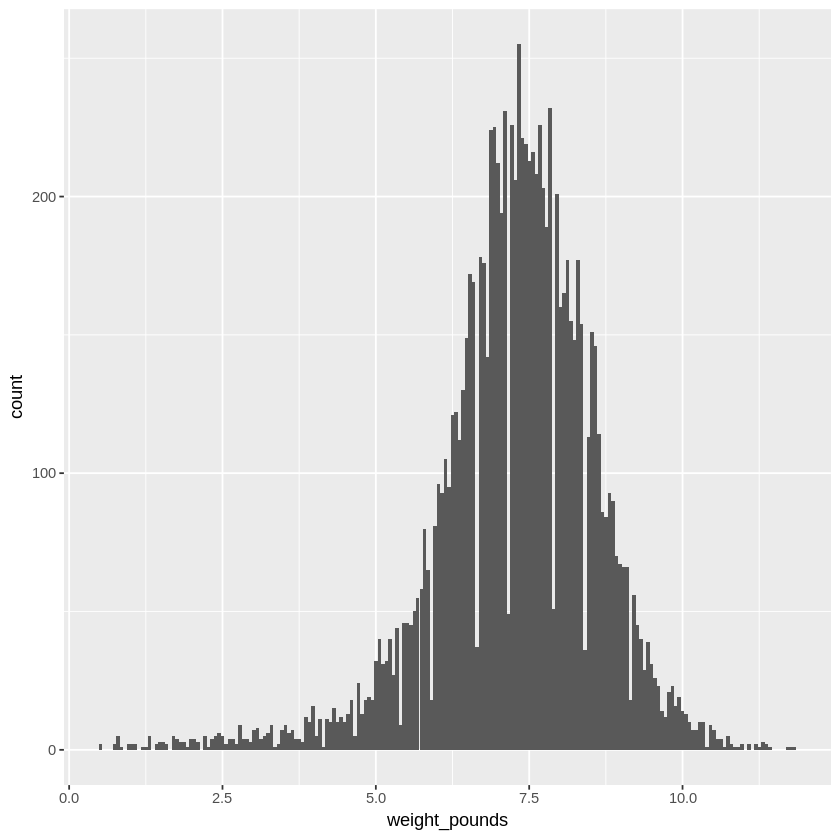

In [9]:
# Display the distribution of the baby weights using a Histogram
ggplot(
    data=natality_data, 
    aes(x = weight_pounds)
) + geom_histogram(bins = 200)

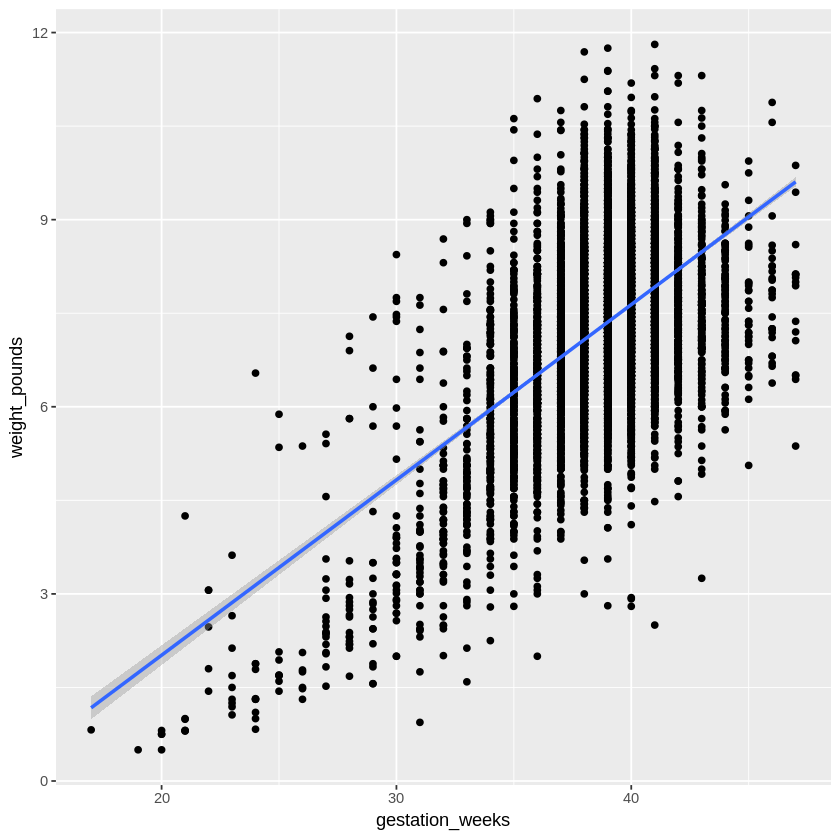

In [10]:
# Display the correlation between the gestations weeks and baby weights 
ggplot(
    data=natality_data, 
    aes(x = gestation_weeks, y = weight_pounds)
) + geom_point() + geom_smooth(method = "lm")

### Performing the processing in BigQuery
Create function that finds the number of records and the average weight for each value of the chosen column

In [11]:
get_distinct_values <- function(column_name) {
    query <- paste0(
        'SELECT ', column_name, ', 
            COUNT(1) AS num_babies,
            AVG(weight_pounds) AS avg_wt
        FROM publicdata.samples.natality
        WHERE year > 2000
        GROUP BY ', column_name)
    query_exec(query, project = PROJECT_ID, useLegacySql = FALSE)
}

2.2 gigabytes processed


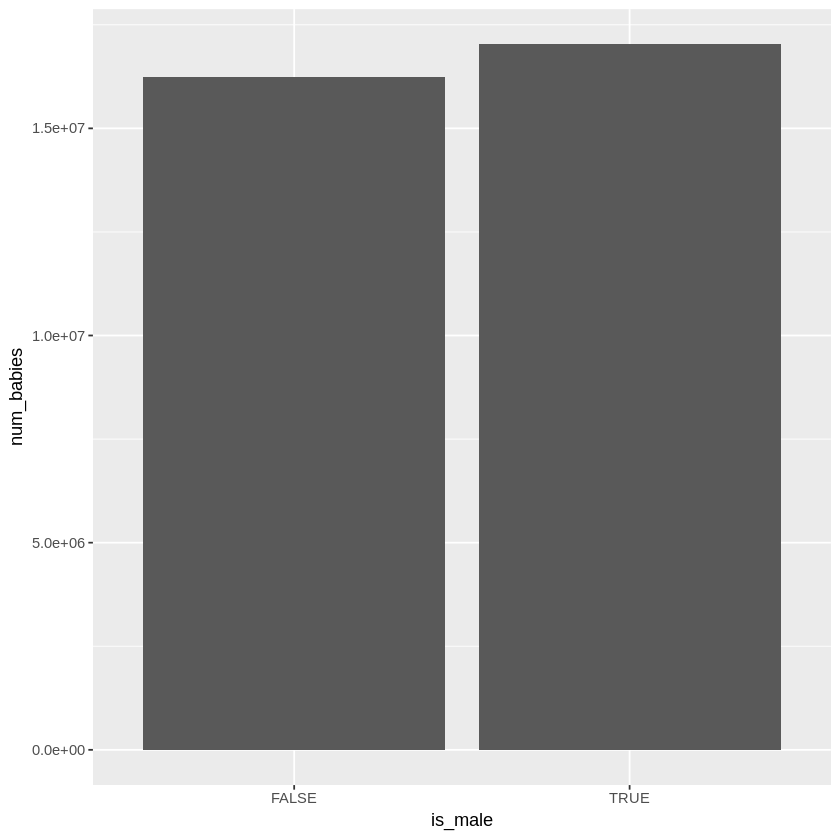

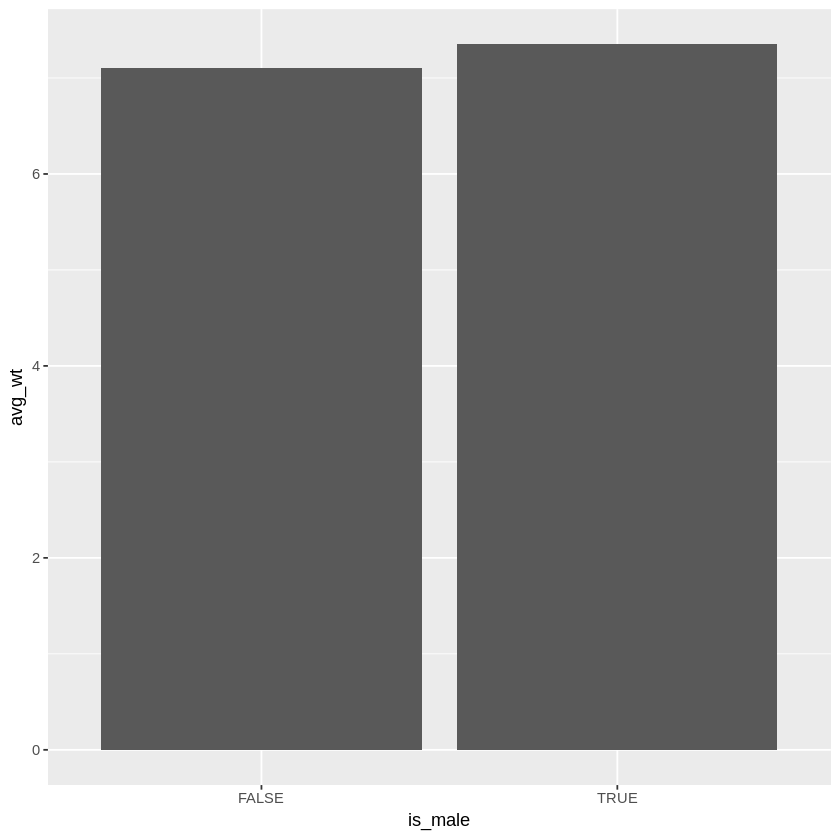

In [12]:
df <- get_distinct_values('is_male')
ggplot(data = df, aes(x = is_male, y = num_babies)) + geom_bar(stat = "identity")
ggplot(data = df, aes(x = is_male, y = avg_wt)) + geom_bar(stat = "identity")

3.1 gigabytes processed


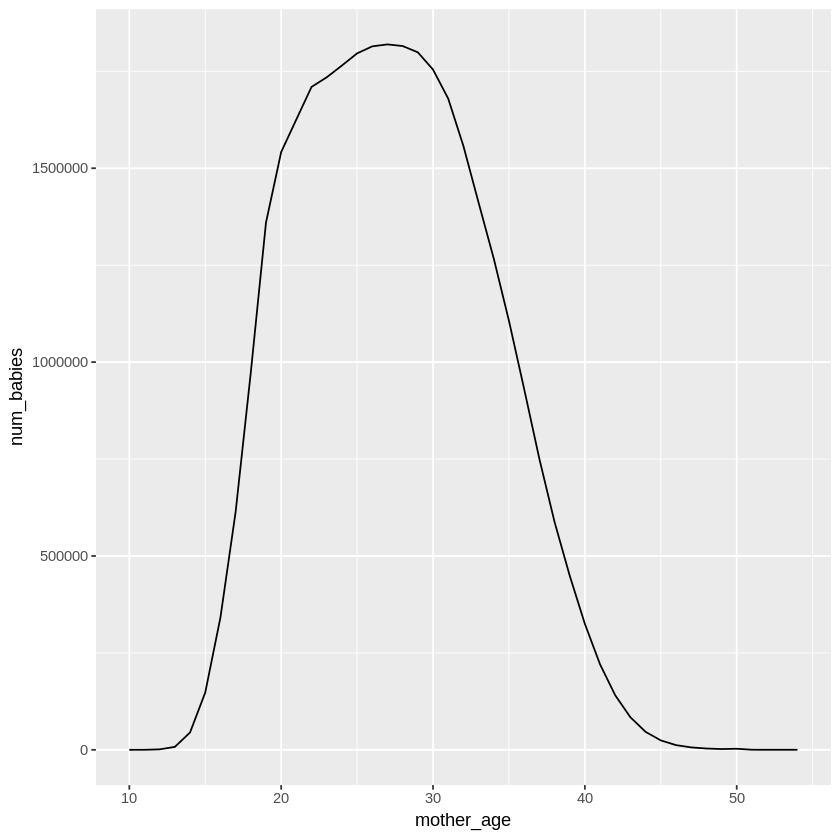

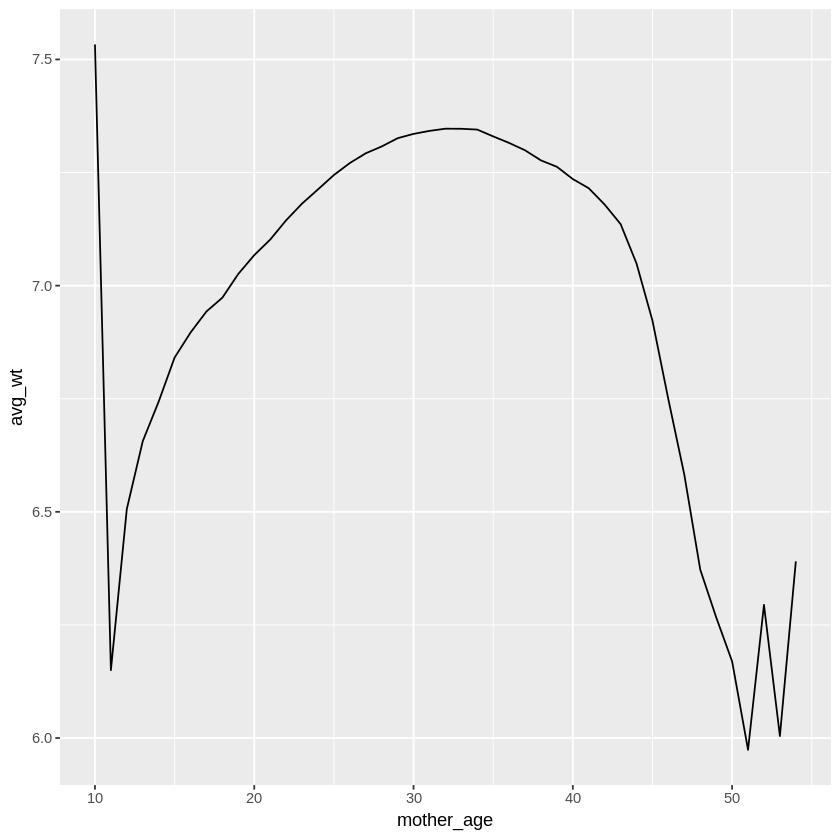

In [13]:
df <- get_distinct_values('mother_age')
ggplot(data = df, aes(x = mother_age, y = num_babies)) + geom_line(stat = "identity")
ggplot(data = df, aes(x = mother_age, y = avg_wt)) + geom_line(stat = "identity")

3.1 gigabytes processed


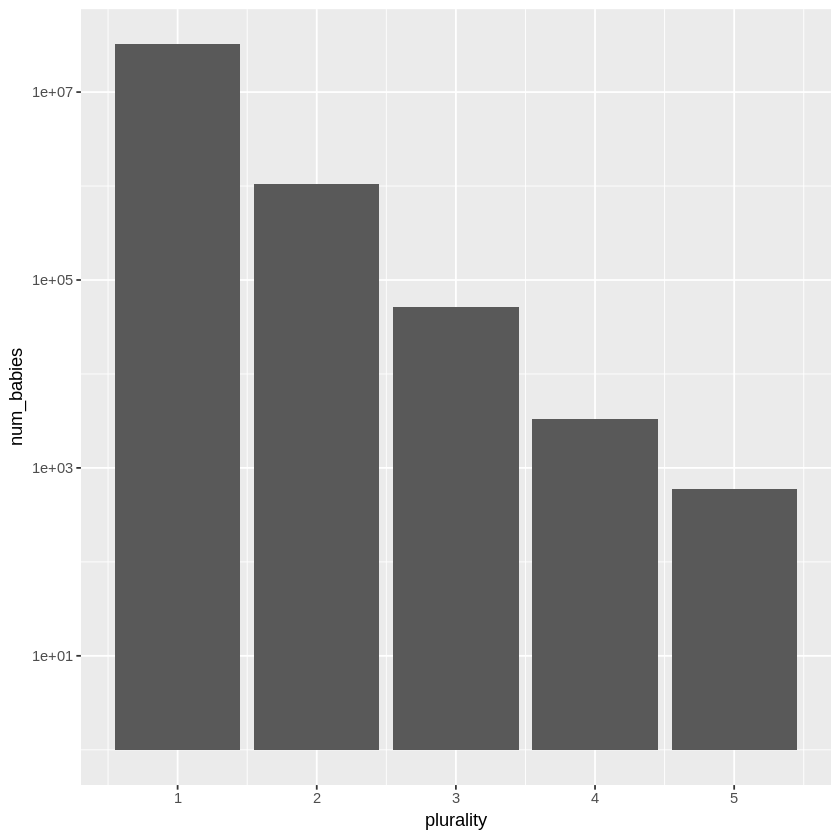

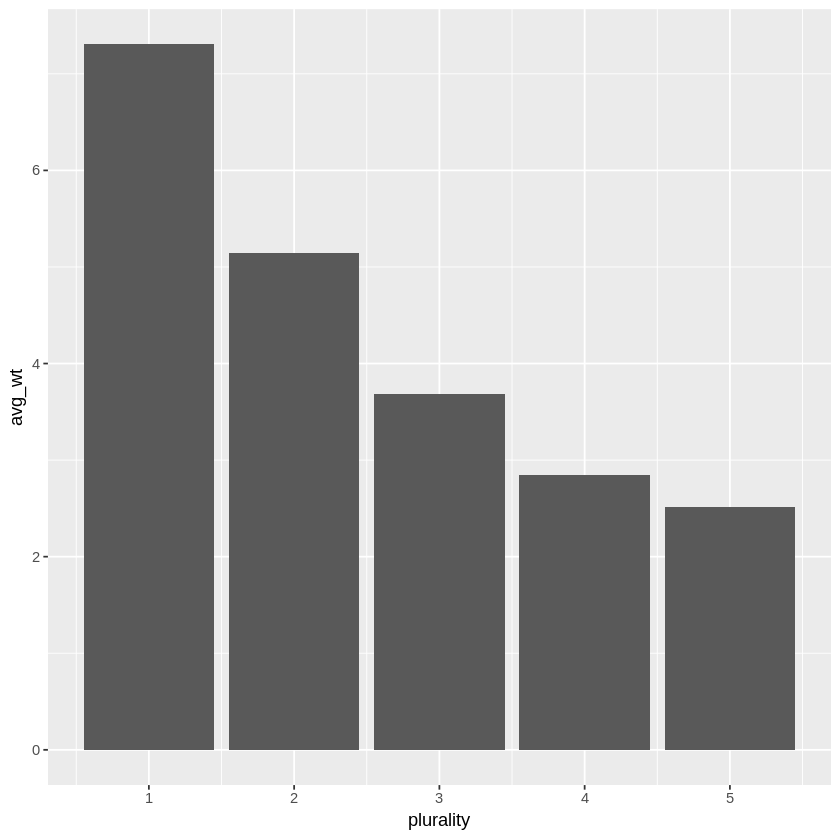

In [14]:
df <- get_distinct_values('plurality')
ggplot(data=df, aes(x=plurality, y=num_babies)) + geom_bar(stat="identity") + scale_y_log10()
ggplot(data=df, aes(x=plurality, y=avg_wt)) + geom_bar(stat = "identity")

3.0 gigabytes processed
Warning message:
“Removed 1 rows containing missing values (position_stack).”

Warning message:
“Removed 1 rows containing missing values (position_stack).”

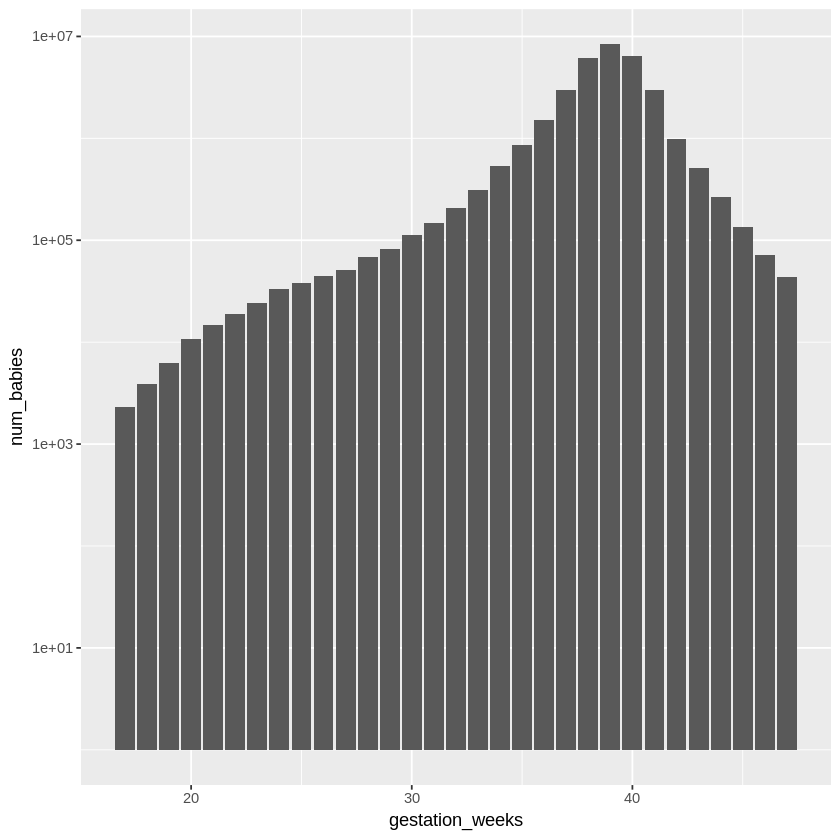

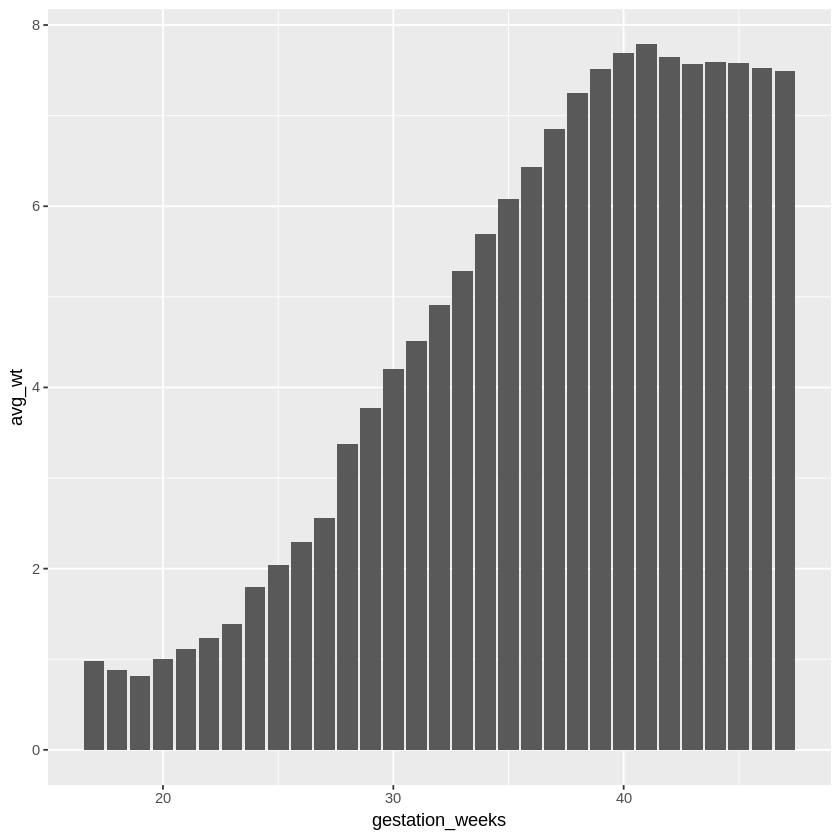

In [15]:
df <- get_distinct_values('gestation_weeks')
ggplot(data = df, aes(x = gestation_weeks, y = num_babies)) + geom_bar(stat = "identity") + scale_y_log10()
ggplot(data = df, aes(x = gestation_weeks, y = avg_wt)) + geom_bar(stat = "identity")

# 3. Saving the data as CSV to GCS

In [16]:
# Prepare train and evaluation data from BigQuery
sample_size <- 10000
sql_query <- sprintf(sql_query, sample_size)

train_query <- paste('SELECT * FROM (', sql_query, ') WHERE MOD(CAST(key AS INT64), 100) <= 75')
eval_query <- paste('SELECT * FROM (', sql_query, ') WHERE MOD(CAST(key AS INT64), 100) > 75')

# Load train data to data.frame
train_data <- bq_table_download(
    bq_project_query(
        PROJECT_ID, 
        query=train_query
    )
)

# Load evaluation data to data.frame
eval_data <- bq_table_download(
    bq_project_query(
        PROJECT_ID, 
        query=eval_query
    )
)

In [17]:
print(paste0("Training instances count: ", nrow(train_data)))
print(paste0("Evaluation instances count: ",nrow(eval_data)))

[1] "Training instances count: 7708"
[1] "Evaluation instances count: 2299"


In [18]:
# Write data frames to a local CSV files, without headers nor row index
dir.create(file.path('data'), showWarnings = FALSE)
write.table(train_data, "data/train_data.csv", row.names=FALSE, col.names=FALSE, sep=",")
write.table(eval_data, "data/eval_data.csv", row.names=FALSE, col.names=FALSE, sep=",")

In [19]:
# Upload CSV data to GCS
gcs_url <- paste0("gs://", BUCKET_NAME, "/")
command <- paste("gsutil mb", gcs_url)
system(command)
gcs_data_dir <- paste0("gs://", BUCKET_NAME, "/data")
command <- paste("gsutil cp data/*_data.csv", gcs_data_dir)
system(command)

In [20]:
command <- paste("gsutil ls -l", gcs_data_dir)
system(command, intern = TRUE)

[1] "    129374  2019-07-25T12:28:50Z  gs://r-on-gcp/data/eval_data.csv" 
[2] "    433171  2019-07-25T12:28:51Z  gs://r-on-gcp/data/train_data.csv"
[3] "TOTAL: 2 objects, 562545 bytes (549.36 KiB)"

## License

Authors: Daniel Sparing & Khalid Salama

---
**Disclaimer**: This is not an official Google product. The sample code provided for an educational purpose.

---

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.